In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model import Model
from tqdm import tqdm
from torch import Tensor
from botorch.acquisition.active_learning import (
    MCSampler,
    qNegIntegratedPosteriorVariance,
)
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.fit import fit_fully_bayesian_model_nuts
from botorch.fit import fit_gpytorch_mll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer,StandardScaler
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model import Model
from sklearn.metrics import mean_absolute_error
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood

from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.means.constant_mean import ConstantMean
from gpytorch.means.mean import Mean
from gpytorch.models.exact_gp import ExactGP
from botorch.models import SingleTaskGP
import os 

In [2]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/ML-guided-NMR_peak_position_predictions/notebooks'

In [3]:
df = pd.read_csv('../data/AutoAM_dataset.csv')
df

,Prime Delay,Print Speed,X Offset Correction,Y Offset Correction,Score
0,0.000000,1.000000,0.000000,0.000000,0.339554
1,2.500000,3.000000,0.100000,0.100000,0.000000
2,5.000000,5.000000,-0.100000,-0.100000,0.218576
3,0.000000,0.999931,0.000006,0.000025,0.368919
4,0.000000,5.070133,0.225151,1.000000,0.000000
...,...,...,...,...,...
95,0.742365,1.714610,-0.380317,-0.416497,0.829756
96,0.000000,1.585934,-0.337143,-0.372811,0.922120
97,0.000000,1.568030,-0.335316,-0.365804,0.901296
98,0.000000,1.558826,-0.349834,-0.328645,0.936549


In [4]:
x_vals = df.iloc[:,:-1]
x_tensors = Tensor(x_vals.values)
x_tensors.shape

y_tensors = Tensor(df.iloc[:,-1].values)

normalizer = Normalizer()
standardizer = StandardScaler()

x = normalizer.fit_transform(x_tensors)
y = standardizer.fit_transform(y_tensors.reshape(-1,1))

In [5]:
# First split: Separate out the candidate set
x_temp, x_candidate, y_temp, y_candidate = train_test_split(
    x, y, test_size=0.70, random_state=42)  # Adjust test_size as needed

# Second split: Divide the remaining data into training and test sets
x_initial, x_test, y_initial, y_test = train_test_split(
    x_temp, y_temp, test_size=0.90, random_state=42)  # Adjust test_size as needed

# Now you have:
# X_candidate, y_candidate - Candidate set
# X_train, y_train - Training set
# X_test, y_test - Test set
print("X_temp:", x_temp.shape, y_temp.shape)
print("Candidate Set:", x_candidate.shape, y_candidate.shape)
print("Initial Set:", x_initial.shape, y_initial.shape)
print("Test Set:", x_test.shape, y_test.shape)


X_temp: (30, 4) (30, 1)
Candidate Set: (70, 4) (70, 1)
Initial Set: (3, 4) (3, 1)
Test Set: (27, 4) (27, 1)


In [6]:
# mps_device = torch.device("cpu")
torch.manual_seed(0)
# mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
mps_device = torch.device("cpu")
dtype = torch.double

mcp = torch.quasirandom.SobolEngine(4, seed=0,scramble=True).draw_base2(9).to(device=mps_device, dtype=dtype)
mcp

tensor([[0.4751, 0.5925, 0.4945, 0.3139],
        [0.8106, 0.4339, 0.7125, 0.8734],
        [0.5718, 0.9770, 0.2237, 0.0569],
        ...,
        [0.5736, 0.0092, 0.3191, 0.8112],
        [0.8088, 0.5911, 0.8695, 0.1198],
        [0.4733, 0.4372, 0.0875, 0.5681]], dtype=torch.float64)

In [8]:
bounds = torch.tensor([[0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0]], device=mps_device, dtype=dtype)

In [9]:
#convert array to tensor
x_init = torch.tensor(x_initial, device=mps_device, dtype=dtype)
x_init

y_init = torch.tensor(y_initial, device=mps_device, dtype=dtype)
y_init

xtest = torch.tensor(x_test, device=mps_device, dtype=dtype)
ytest = torch.tensor(y_test, device=mps_device, dtype=dtype)

x_candidates = torch.tensor(x_candidate, device=mps_device, dtype=dtype)
y_candidates = torch.tensor(y_candidate, device=mps_device, dtype=dtype)

In [10]:
print(x_init.shape)
print(y_init.shape)
print(xtest.shape)
print(ytest.shape)
print(x_candidates.shape)
print(y_candidates.shape)


torch.Size([3, 4])
torch.Size([3, 1])
torch.Size([27, 4])
torch.Size([27, 1])
torch.Size([70, 4])
torch.Size([70, 1])


In [11]:
def find_max_normalized_acqval(tensor_list, qNIVP):
    max_value = None
    max_index = -1
    acq_val_lst = []
    # torch.manual_seed(13)
    for i, tensor_ in enumerate(tensor_list):
        tensor = tensor_.unsqueeze(0)
        qNIVP_val = qNIVP(tensor)
        acq_val_lst.append(qNIVP_val.item())  # Assuming it's a scalar tensor

        # Check if this is the maximum value so far
        if max_value is None or qNIVP_val > max_value:
            max_value = qNIVP_val
            max_index = i

    return max_value, max_index, acq_val_lst

In [12]:
xcandidates = x_candidates.clone()
ycandidates = y_candidates.clone()

xinit = x_init.clone()
yinit = y_init.clone()

In [13]:
rand_selection_mae = []
xmax_candidates = []
pred_mae = []
pred_y = []
pred_std = []


gp = SingleTaskGP(xinit, yinit)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)
posterior = gp(xtest)
ypred = posterior.mean.detach().numpy()
ystd = posterior.stddev.detach().numpy()

pred_y.append(ypred)
pred_std.append(ystd)


# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel


# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)


for i in tqdm(range(25)):
    # if not xcandidates:
    #     break
    
    qNIVP = qNegIntegratedPosteriorVariance(gp, mc_points= mcp)
    
    
    max_value, max_index, acq_val_lst = find_max_normalized_acqval(xcandidates, qNIVP)
    xmax_candidates.append(max_index)
    print("len of tensor:",len(xcandidates[max_index]))
    print("tensor shape:",xcandidates[max_index].shape)
    print("candidate tensor",xcandidates[max_index])
    print("shape of xinit:",xinit.shape)
    # add the new point to the training set
    
    
    xinit= torch.cat((xinit, xcandidates[max_index].unsqueeze(0)), 0)
    yinit = torch.cat((yinit, ycandidates[max_index].unsqueeze(0)), 0)
    
    print('len of new train:', len(xinit))
        
    xcandidates = torch.cat((xcandidates[:max_index], xcandidates[max_index + 1:]))
    ycandidates = torch.cat((ycandidates[:max_index], ycandidates[max_index + 1:]))
    
    
    gp = SingleTaskGP(xinit, yinit) 
    # gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    ypred = gp(xtest)
    ypred_mean = ypred.mean.detach().numpy()
    pred_y.append(ypred_mean)

    #calculate the mean absolute error and the standard deviation for the test set
    ymae = mean_absolute_error(ytest, ypred_mean)
    print('mean absolute error: ', ymae)
    pred_mae.append(ymae)
    ystd = gp(xtest).stddev
    ystd = ystd.detach().numpy()
    pred_std.append(ystd)


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0159], dtype=torch.float64), std = tensor([1.5678], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
  0%|          | 0/25 [00:00<?, ?it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y

len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([0.7740, 0.5941, 0.1548, 0.1548], dtype=torch.float64)
shape of xinit: torch.Size([3, 4])
len of new train: 4
mean absolute error:  0.768023455306148


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.6827], dtype=torch.float64), std = tensor([1.4643], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([0.0000, 0.0705, 0.7053, 0.7053], dtype=torch.float64)
shape of xinit: torch.Size([4, 4])
len of new train: 5
mean absolute error:  0.7756100205181972


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.7774], dtype=torch.float64), std = tensor([1.3301], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([0.0000, 0.9249, 0.0794, 0.3718], dtype=torch.float64)
shape of xinit: torch.Size([5, 4])
len of new train: 6
mean absolute error:  0.7453005860727425


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.8020], dtype=torch.float64), std = tensor([1.2159], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.9924,  0.0317, -0.0906,  0.0766], dtype=torch.float64)
shape of xinit: torch.Size([6, 4])
len of new train: 7
mean absolute error:  0.7410327472861888


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.9181], dtype=torch.float64), std = tensor([1.1727], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.4447,  0.8895, -0.0562,  0.0889], dtype=torch.float64)
shape of xinit: torch.Size([7, 4])
len of new train: 8
mean absolute error:  0.7563751818437068


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-1.0084], dtype=torch.float64), std = tensor([1.1299], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.4437,  0.8874,  0.0887, -0.0887], dtype=torch.float64)
shape of xinit: torch.Size([8, 4])
len of new train: 9
mean absolute error:  0.8623103870272351


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.8644], dtype=torch.float64), std = tensor([1.1585], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.4452,  0.8903, -0.0350, -0.0890], dtype=torch.float64)
shape of xinit: torch.Size([9, 4])
len of new train: 10
mean absolute error:  0.6368600854983621


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.9432], dtype=torch.float64), std = tensor([1.1297], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([0.0000, 0.9802, 0.0435, 0.1933], dtype=torch.float64)
shape of xinit: torch.Size([10, 4])
len of new train: 11
mean absolute error:  0.4476533933154172


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.9927], dtype=torch.float64), std = tensor([1.0907], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.9797,  0.0196,  0.0385, -0.1959], dtype=torch.float64)
shape of xinit: torch.Size([11, 4])
len of new train: 12
mean absolute error:  0.4688380051195801


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.9778], dtype=torch.float64), std = tensor([1.0456], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.0000,  0.9871, -0.0348,  0.1561], dtype=torch.float64)
shape of xinit: torch.Size([12, 4])
len of new train: 13
mean absolute error:  0.4968519297067964


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.8762], dtype=torch.float64), std = tensor([1.0741], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.6926,  0.7065, -0.0447, -0.1385], dtype=torch.float64)
shape of xinit: torch.Size([13, 4])
len of new train: 14
mean absolute error:  0.37529862089246774


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.8503], dtype=torch.float64), std = tensor([1.0399], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([0.0000e+00, 1.0000e+00, 5.5404e-06, 2.5202e-05], dtype=torch.float64)
shape of xinit: torch.Size([14, 4])
len of new train: 15
mean absolute error:  0.37200197161474857


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.7906], dtype=torch.float64), std = tensor([1.0326], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.9794,  0.0196, -0.0441, -0.1959], dtype=torch.float64)
shape of xinit: torch.Size([15, 4])
len of new train: 16
mean absolute error:  0.3649526267649024


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.7678], dtype=torch.float64), std = tensor([1.0042], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.4454,  0.8909, -0.0027, -0.0891], dtype=torch.float64)
shape of xinit: torch.Size([16, 4])
len of new train: 17
mean absolute error:  0.3660410078946778


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.8212], dtype=torch.float64), std = tensor([1.0003], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.9594,  0.1619, -0.2309,  0.0068], dtype=torch.float64)
shape of xinit: torch.Size([17, 4])
len of new train: 18
mean absolute error:  0.3456727231706812


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.7755], dtype=torch.float64), std = tensor([0.9924], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.6094,  0.7878, -0.0575, -0.0687], dtype=torch.float64)
shape of xinit: torch.Size([18, 4])
len of new train: 19
mean absolute error:  0.3525698198542462


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.7853], dtype=torch.float64), std = tensor([0.9670], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.0000,  0.9950,  0.0069, -0.0995], dtype=torch.float64)
shape of xinit: torch.Size([19, 4])
len of new train: 20
mean absolute error:  0.31734355401691694


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.7629], dtype=torch.float64), std = tensor([0.9480], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.0414,  0.9969, -0.0392,  0.0535], dtype=torch.float64)
shape of xinit: torch.Size([20, 4])
len of new train: 21
mean absolute error:  0.32468694165604606


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.7043], dtype=torch.float64), std = tensor([0.9651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.5836,  0.7894, -0.0668, -0.1785], dtype=torch.float64)
shape of xinit: torch.Size([21, 4])
len of new train: 22
mean absolute error:  0.31066870250384376


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.6424], dtype=torch.float64), std = tensor([0.9886], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.0000,  0.9957, -0.0896,  0.0253], dtype=torch.float64)
shape of xinit: torch.Size([22, 4])
len of new train: 23
mean absolute error:  0.3090942228924608


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.6042], dtype=torch.float64), std = tensor([0.9848], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.0000,  0.9964, -0.0532, -0.0662], dtype=torch.float64)
shape of xinit: torch.Size([23, 4])
len of new train: 24
mean absolute error:  0.3079304289067833


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.6035], dtype=torch.float64), std = tensor([0.9641], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([0., 1., 0., 0.], dtype=torch.float64)
shape of xinit: torch.Size([24, 4])
len of new train: 25
mean absolute error:  0.3109548337595278


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.5990], dtype=torch.float64), std = tensor([0.9449], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.0000,  0.9992, -0.0308, -0.0268], dtype=torch.float64)
shape of xinit: torch.Size([25, 4])
len of new train: 26
mean absolute error:  0.31056943177229346


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.5564], dtype=torch.float64), std = tensor([0.9526], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.2859,  0.9362, -0.0544, -0.1969], dtype=torch.float64)
shape of xinit: torch.Size([26, 4])
len of new train: 27
mean absolute error:  0.31314232514275914


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/gpytorch.py:106: BotorchTensorDimensionWarning: Non-strict enforcement of botorch tensor conventions. The following error would have been raised with strict enforcement: Expected X and Y to have the same number of dimensions (got X with dimension 3 and Y with dimension 4).
  warnings.warn(
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.5414], dtype=torch.float64), std = tensor([0.9382], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


len of tensor: 4
tensor shape: torch.Size([4])
candidate tensor tensor([ 0.9770,  0.0195, -0.0827, -0.1954], dtype=torch.float64)
shape of xinit: torch.Size([27, 4])
len of new train: 28
mean absolute error:  0.31877343320702634


In [18]:
xcandidates_rand = x_candidates.clone()
ycandidates_rand = y_candidates.clone()

xinit_rand = x_init.clone()
yinit_rand = y_init.clone()

In [60]:
import random
torch.manual_seed(13)
random.seed(1000)

rand_xmax_candidates = []
rand_pred_mae = []
rand_pred_std = []
rand_pred_mean = []

# rbf_kernel = kernels.RBFKernel()

# combined_kernel = periodic_kernel * rbf_kernel
random_mae_seeds =[]

# gp = SingleTaskGP(xinit, ytrain_,covar_module=rbf_kernel)
random_seeds = [0,13,90,14,12]
for seed in random_seeds:
    random.seed(seed)
    xcandidates_rand = x_candidates.clone()
    ycandidates_rand = y_candidates.clone()

    xinit_rand = x_init.clone()
    yinit_rand = y_init.clone()
    
    rand_xmax_candidates = []
    rand_pred_mae = []
    rand_pred_std = []
    rand_pred_mean = []

    gp = SingleTaskGP(xinit_rand, yinit_rand) 
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    #predict the y values for the test set
    rand_ypred = gp(xtest)
    rand_ypred_mean = rand_ypred.mean.detach().numpy()
    rand_pred_mean.append(rand_ypred_mean)
    #calculate the mean absolute error and the standard deviation for the test set
    rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
    print('mean absolute error: ', rand_ymae)
    rand_pred_mae.append(rand_ymae)
        
    rand_ystd = gp(xtest).stddev
    ystd_ = rand_ystd.detach().numpy()
    rand_pred_std.append(ystd_)
    print("initial len of xinit", len(xinit_rand))
    
    
    
    for i in tqdm(range(25)):
        # if xcandidates_rand.numel() == 0:
        #     break
        
        # Randomly select an index
        rand_select = random.randint(0, len(xcandidates_rand) - 1)
        
        # Add the selected tensor to the training sets
        xinit_rand = torch.cat((xinit_rand, xcandidates_rand[rand_select].unsqueeze(0)), 0)
        yinit_rand = torch.cat((yinit_rand, ycandidates_rand[rand_select].unsqueeze(0)), 0)
        
        # Print the length of new training set
        print('len of new train:', len(xinit_rand))

        # Remove the selected tensor from xcandidates and ycandidates
        xcandidates_rand = torch.cat((xcandidates_rand[:rand_select], xcandidates_rand[rand_select + 1:]))
        ycandidates_rand = torch.cat((ycandidates_rand[:rand_select], ycandidates_rand[rand_select + 1:]))
        
        # Update GP model, fit and predict
        gp = SingleTaskGP(xinit_rand, yinit_rand) 
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        
        # Predict the y values for the test set and calculate errors
        rand_ypred = gp(xtest)
        rand_ypred_mean = rand_ypred.mean.detach().numpy()
        rand_pred_mean.append(rand_ypred_mean)
        
        rand_ymae = mean_absolute_error(ytest, rand_ypred_mean)
        print('mean absolute error: ', rand_ymae)
        rand_pred_mae.append(rand_ymae)
        
        rand_ystd = gp(xtest).stddev
        ystd_ = rand_ystd.detach().numpy()
        rand_pred_std.append(ystd_)
    random_mae_seeds.append(rand_pred_mae)


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0159], dtype=torch.float64), std = tensor([1.5678], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mean absolute error:  0.7614795984793835
initial len of xinit 3


  0%|          | 0/25 [00:00<?, ?it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.1879], dtype=torch.float64), std = tensor([1.3434], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorc

len of new train: 4
mean absolute error:  0.7027845279877981
len of new train: 5
mean absolute error:  0.9352409988616635
len of new train: 6
mean absolute error:  0.8142553221718417
len of new train: 7
mean absolute error:  0.7238802186249237
len of new train: 8
mean absolute error:  0.8203009852349475
len of new train: 9
mean absolute error:  0.7961087327757137
len of new train: 10


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1052], dtype=torch.float64), std = tensor([1.2297], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.8192574960816474
len of new train: 11
mean absolute error:  0.7821369466782159
len of new train: 12
mean absolute error:  0.7811238521146554
len of new train: 13


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.2297], dtype=torch.float64), std = tensor([1.0694], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.7568539878236998
len of new train: 14
mean absolute error:  0.7397331210842845
len of new train: 15
mean absolute error:  0.7527975268698694


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.3175], dtype=torch.float64), std = tensor([1.0248], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 48%|████▊     | 12/25 [00:00<00:00, 14.67it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

len of new train: 16
mean absolute error:  0.6212917728757702
len of new train: 17
mean absolute error:  0.6171925548519437
len of new train: 18
mean absolute error:  0.609921922764886
len of new train: 19
mean absolute error:  0.6129737693439524
len of new train: 20
mean absolute error:  0.6190722361357457
len of new train: 21
mean absolute error:  0.6133996244282236
len of new train: 22


 76%|███████▌  | 19/25 [00:00<00:00, 21.29it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1477], dtype=torch.float64), std = tensor([1.0719], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

mean absolute error:  0.5098190922741828
len of new train: 23
mean absolute error:  0.47420972425590524
len of new train: 24
mean absolute error:  0.5404629898234623
len of new train: 25


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1361], dtype=torch.float64), std = tensor([1.0633], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 88%|████████▊ | 22/25 [00:01<00:00, 15.73it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

mean absolute error:  0.538630416535566
len of new train: 26
mean absolute error:  0.46525527384456256
len of new train: 27
mean absolute error:  0.5486401584127049
len of new train: 28


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1250], dtype=torch.float64), std = tensor([1.0229], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.5420797607868727
mean absolute error:  0.7614795984793835
initial len of xinit 3


  0%|          | 0/25 [00:00<?, ?it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0242], dtype=torch.float64), std = tensor([1.2802], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch

len of new train: 4
mean absolute error:  0.6215447200027376
len of new train: 5
mean absolute error:  0.6499128948738153
len of new train: 6
mean absolute error:  0.6121001477079216
len of new train: 7
mean absolute error:  0.6084169526532196
len of new train: 8
mean absolute error:  0.6395149845732546
len of new train: 9
mean absolute error:  0.46034485113958323
len of new train: 10


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0632], dtype=torch.float64), std = tensor([0.8762], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.48228685230467827
len of new train: 11
mean absolute error:  0.42477019972653135
len of new train: 12
mean absolute error:  0.41625082953147086
len of new train: 13
mean absolute error:  0.4006252131471463
len of new train: 14


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0491], dtype=torch.float64), std = tensor([0.9419], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.38277834734755106
len of new train: 15
mean absolute error:  0.3394908144599254
len of new train: 16
mean absolute error:  0.3401898170170557
len of new train: 17
mean absolute error:  0.34616424082571945
len of new train: 18


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.1206], dtype=torch.float64), std = tensor([0.9337], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.32490171922031164
len of new train: 19
mean absolute error:  0.3368046919169758
len of new train: 20
mean absolute error:  0.3307620468916888
len of new train: 21


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0737], dtype=torch.float64), std = tensor([0.8854], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.3255184790116683
len of new train: 22
mean absolute error:  0.3363728360822326
len of new train: 23


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0430], dtype=torch.float64), std = tensor([0.9073], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 80%|████████  | 20/25 [00:01<00:00, 14.60it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

mean absolute error:  0.2938640025036005
len of new train: 24
mean absolute error:  0.2935251517303604
len of new train: 25
mean absolute error:  0.28885543992842605
len of new train: 26


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1188], dtype=torch.float64), std = tensor([0.9325], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.29097286122864613
len of new train: 27
mean absolute error:  0.3016032627903023
len of new train: 28
mean absolute error:  0.29758955396023334
mean absolute error:  0.7614795984793835
initial len of xinit 3


  0%|          | 0/25 [00:00<?, ?it/s]

len of new train: 4
mean absolute error:  0.6779936438564491
len of new train: 5
mean absolute error:  0.6252463657508736
len of new train: 6


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1231], dtype=torch.float64), std = tensor([1.2979], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.5339518079582742
len of new train: 7
mean absolute error:  0.546492443754735
len of new train: 8
mean absolute error:  0.5490488766228866
len of new train: 9
mean absolute error:  0.5492131391578404
len of new train: 10
mean absolute error:  0.550592853302888
len of new train: 11


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.3423], dtype=torch.float64), std = tensor([1.2242], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.5610009957500371
len of new train: 12
mean absolute error:  0.554274249984214
len of new train: 13
mean absolute error:  0.5757850109427446
len of new train: 14


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.1173], dtype=torch.float64), std = tensor([1.2308], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 44%|████▍     | 11/25 [00:00<00:00, 17.58it/s]

mean absolute error:  0.5761000414879083
len of new train: 15
mean absolute error:  0.6097234454966705
len of new train: 16


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0801], dtype=torch.float64), std = tensor([1.1947], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.5974040552511007
len of new train: 17


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0341], dtype=torch.float64), std = tensor([1.1648], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.570646456288495
len of new train: 18
mean absolute error:  0.33326300379091905
len of new train: 19


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0213], dtype=torch.float64), std = tensor([1.1849], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.3564592422969292
len of new train: 20
mean absolute error:  0.3229740022220599
len of new train: 21


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0355], dtype=torch.float64), std = tensor([1.1259], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.33871281208305637
len of new train: 22
mean absolute error:  0.3519556115839503
len of new train: 23
mean absolute error:  0.313386174541755
len of new train: 24


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0213], dtype=torch.float64), std = tensor([1.1244], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.30978293438437904
len of new train: 25
mean absolute error:  0.305046580373796
len of new train: 26
mean absolute error:  0.4502092882401393
len of new train: 27
mean absolute error:  0.4486499272362852
len of new train: 28
mean absolute error:  0.4399360080646358
mean absolute error:  0.7614795984793835
initial len of xinit 3


  0%|          | 0/25 [00:00<?, ?it/s]

len of new train: 4


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.4207], dtype=torch.float64), std = tensor([1.5496], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.9722443920803397
len of new train: 5
mean absolute error:  0.9249349359591378
len of new train: 6
mean absolute error:  1.041109092831289
len of new train: 7
mean absolute error:  0.9364687080698365
len of new train: 8


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0342], dtype=torch.float64), std = tensor([1.3542], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 24%|██▍       | 6/25 [00:00<00:00, 20.81it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

mean absolute error:  0.8442875766965168
len of new train: 9
mean absolute error:  0.8217472310195395
len of new train: 10
mean absolute error:  0.7316679800340812
len of new train: 11
mean absolute error:  0.7378208871772342
len of new train: 12


 36%|███▌      | 9/25 [00:00<00:00, 18.61it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0878], dtype=torch.float64), std = tensor([1.1736], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mean absolute error:  0.7408148445561089
len of new train: 13
mean absolute error:  0.7651209998130403
len of new train: 14


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0078], dtype=torch.float64), std = tensor([1.1829], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 44%|████▍     | 11/25 [00:00<00:01, 12.65it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packag

mean absolute error:  0.76352441016169
len of new train: 15
mean absolute error:  0.7542597765840469
len of new train: 16
mean absolute error:  0.6156604505985807
len of new train: 17


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0837], dtype=torch.float64), std = tensor([1.1529], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.654981889284147
len of new train: 18
mean absolute error:  0.6434291053653907
len of new train: 19
mean absolute error:  0.6382236003641504
len of new train: 20
mean absolute error:  0.6177004596036026
len of new train: 21
mean absolute error:  0.5505285102843634
len of new train: 22
mean absolute error:  0.5745993616683398
len of new train: 23


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0246], dtype=torch.float64), std = tensor([1.0725], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 80%|████████  | 20/25 [00:01<00:00, 19.21it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

mean absolute error:  0.5586735770218111
len of new train: 24
mean absolute error:  0.5764690739995322
len of new train: 25


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0106], dtype=torch.float64), std = tensor([1.0143], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 92%|█████████▏| 23/25 [00:01<00:00, 16.01it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packag

mean absolute error:  0.5593467333441906
len of new train: 26
mean absolute error:  0.5113509135471725
len of new train: 27
mean absolute error:  0.5500902505166619
len of new train: 28
mean absolute error:  0.5078374211370741



/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0159], dtype=torch.float64), std = tensor([1.5678], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


mean absolute error:  0.7614795984793835
initial len of xinit 3


  0%|          | 0/25 [00:00<?, ?it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1657], dtype=torch.float64), std = tensor([1.3147], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch

len of new train: 4
mean absolute error:  0.7248917190468953
len of new train: 5
mean absolute error:  0.7089732748687037
len of new train: 6
mean absolute error:  0.7209003828031078
len of new train: 7


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1568], dtype=torch.float64), std = tensor([1.2767], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 20%|██        | 5/25 [00:00<00:01, 10.82it/s]

mean absolute error:  0.7181746115514478
len of new train: 8
mean absolute error:  0.6967738438975646
len of new train: 9


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0852], dtype=torch.float64), std = tensor([1.2134], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.5963428921312314
len of new train: 10
mean absolute error:  0.5083324934129229
len of new train: 11


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1234], dtype=torch.float64), std = tensor([1.0941], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDa

mean absolute error:  0.5161240283971947
len of new train: 12
mean absolute error:  0.3743969470846599
len of new train: 13


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.1405], dtype=torch.float64), std = tensor([1.0025], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 40%|████      | 10/25 [00:01<00:01,  8.57it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

mean absolute error:  0.3780559437700481
len of new train: 14
mean absolute error:  0.4263527518035133
len of new train: 15


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.0313], dtype=torch.float64), std = tensor([1.0501], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
 48%|████▊     | 12/25 [00:01<00:01,  7.92it/s]/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-package

mean absolute error:  0.38642200148277284
len of new train: 16
mean absolute error:  0.38907497412378395
len of new train: 17
mean absolute error:  0.639168446163061
len of new train: 18
mean absolute error:  0.585600909531427
len of new train: 19


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.1477], dtype=torch.float64), std = tensor([1.1079], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.5596549914500782
len of new train: 20
mean absolute error:  0.5500520493710832
len of new train: 21
mean absolute error:  0.5463614130629065
len of new train: 22
mean absolute error:  0.516957744487035
len of new train: 23
mean absolute error:  0.5161237759721592
len of new train: 24
mean absolute error:  0.5220889195151547
len of new train: 25
mean absolute error:  0.5188297990844651
len of new train: 26


/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0010], dtype=torch.float64), std = tensor([1.0651], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/ramseyissa/miniconda3/envs/nmr_peaks/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputD

mean absolute error:  0.5269351256547322
len of new train: 27
mean absolute error:  0.5112257385810568
len of new train: 28
mean absolute error:  0.5910378631648514


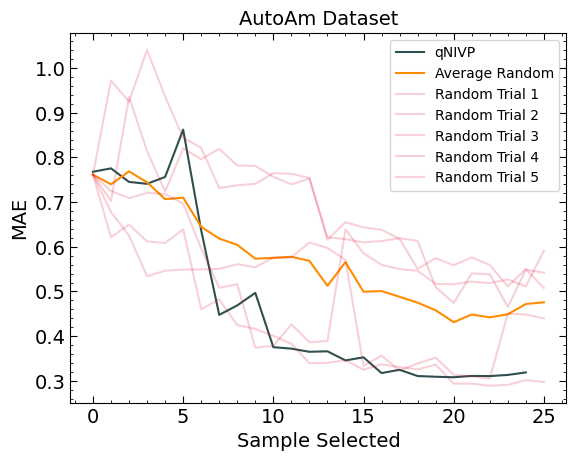

In [62]:
average_mae = np.mean(random_mae_seeds, axis=0)
random_trials = [1,2,3,4,5]

plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(average_mae, color='darkorange', label='Average Random')
colors = ['crimson','crimson','crimson','crimson','crimson']
for mae_values, seed, color in zip(random_mae_seeds, random_trials, colors):
    plt.plot(mae_values, label=f'Random Trial {seed}', color=color,alpha=0.2)

plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('AutoAm Dataset', size=14)
plt.xlabel('Sample Selected', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()


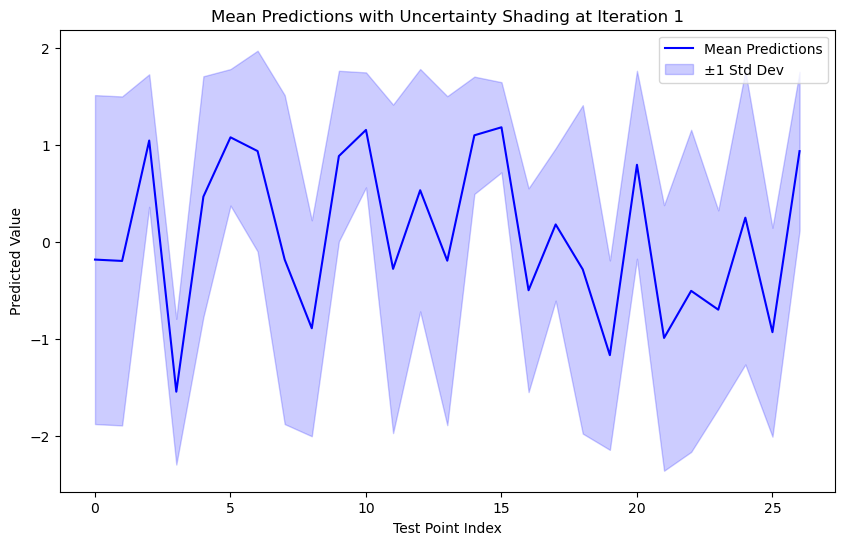

In [54]:
# Assuming you have numpy arrays from your previous discussion
pred_y_np = np.array(pred_y)  # mean predictions over iterations
pred_std_np = np.array(pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 0
means = pred_y_np[iteration_index]
std_devs = pred_std_np[iteration_index]

# Generate indices for x-axis
x_values = np.arange(len(means))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, means, label='Mean Predictions', color='blue')
plt.fill_between(x_values, means - std_devs, means + std_devs, color='blue', alpha=0.2, label='±1 Std Dev')

plt.title('Mean Predictions with Uncertainty Shading at Iteration {}'.format(iteration_index + 1))
plt.xlabel('Test Point Index')
plt.ylabel('Predicted Value')
plt.legend()
# plt.grid(True)
plt.show()



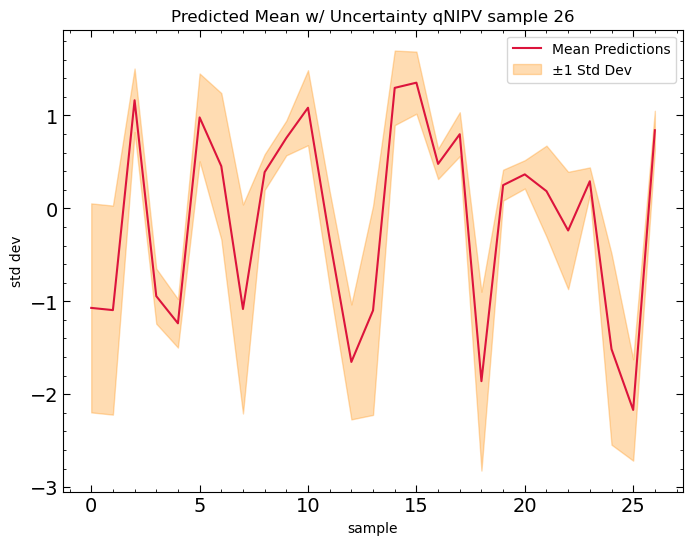

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have numpy arrays from your previous discussion
pred_y_np = np.array(pred_y)  # mean predictions over iterations
pred_std_np = np.array(pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 25
means = pred_y_np[iteration_index]
std_devs = pred_std_np[iteration_index]

# Generate indices for x-axis
x_values = np.arange(len(means))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values, means, label='Mean Predictions', color='crimson')
plt.fill_between(x_values, means - std_devs, means + std_devs, color='darkorange', alpha=0.3, label='±1 Std Dev')

plt.title('Predicted Mean w/ Uncertainty qNIPV sample {}'.format(iteration_index + 1))
plt.xlabel('sample')
plt.ylabel('std dev')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.legend()
# plt.grid(True)
plt.show()

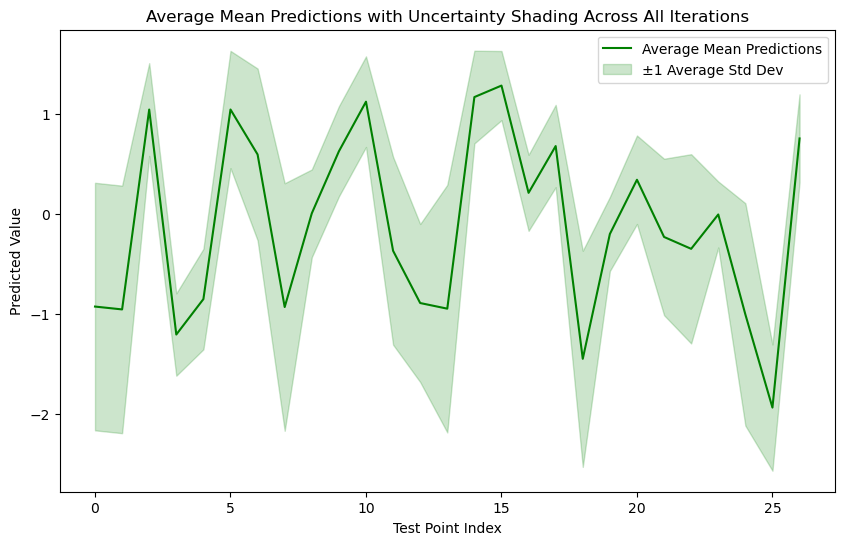

In [49]:
# Calculate average means and standard deviations across all iterations
average_means = np.mean(pred_y_np, axis=0)
average_stds = np.mean(pred_std_np, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, average_means, label='Average Mean Predictions', color='green')
plt.fill_between(x_values, average_means - average_stds, average_means + average_stds, color='green', alpha=0.2, label='±1 Average Std Dev')

plt.title('Average Mean Predictions with Uncertainty Shading Across All Iterations')
plt.xlabel('Samples Added')
plt.ylabel('STD')
plt.legend()
# plt.grid(True)
plt.show()


### random

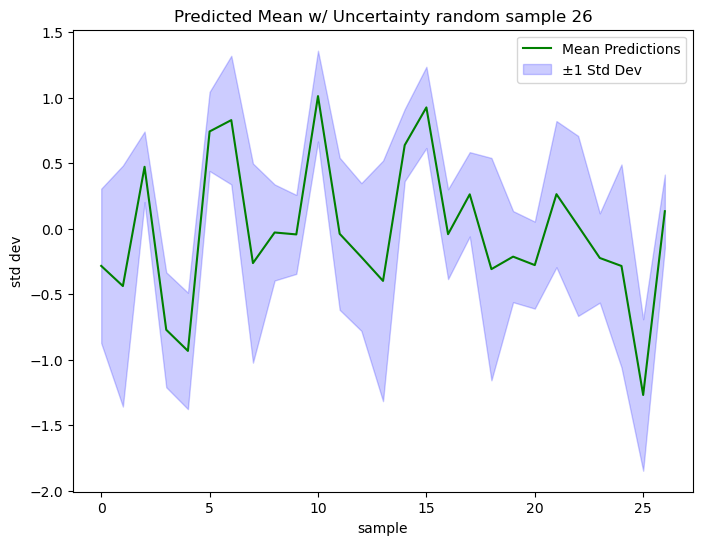

In [91]:
# Assuming you have numpy arrays from your previous discussion
rand_pred_y_np = np.array(rand_pred_mean)  # mean predictions over iterations
rand_pred_std_np = np.array(rand_pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 25
means_rand = rand_pred_y_np[iteration_index]
std_devs_rand = rand_pred_std_np[iteration_index]

# Generate indices for x-axis
x_values_rand = np.arange(len(means_rand))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values, means_rand, label='Mean Predictions', color='green')
plt.fill_between(x_values_rand, means_rand - std_devs_rand, means_rand + std_devs_rand, color='blue', alpha=0.2, label='±1 Std Dev')

plt.title('Predicted Mean w/ Uncertainty random sample {}'.format(iteration_index + 1))
plt.xlabel('sample')
plt.ylabel('std dev')
plt.legend()
# plt.grid(True)
plt.show()

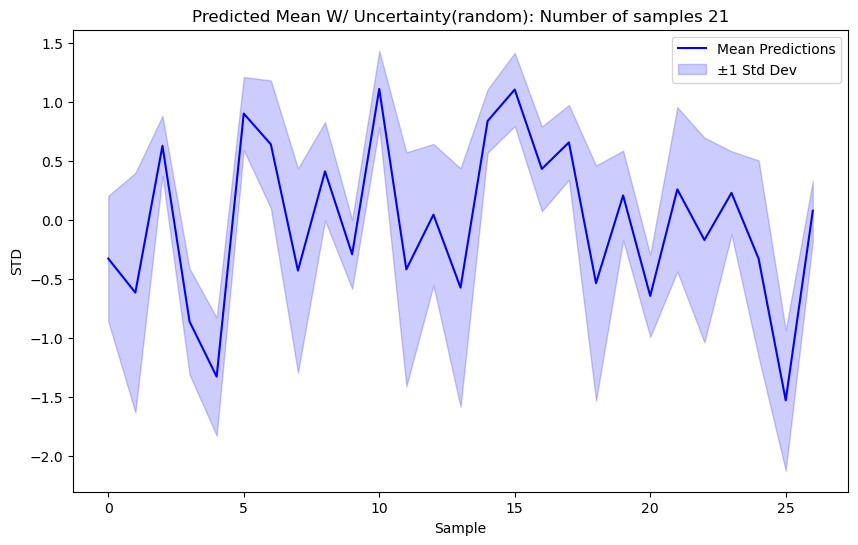

In [69]:
rand_pred_y_np = np.array(rand_pred_mean)  # mean predictions over iterations
rand_pred_std_np = np.array(rand_pred_std)  # standard deviations over iterations

# Select an iteration index
iteration_index = 20
means_rand = rand_pred_y_np[iteration_index]
std_devs_rand = rand_pred_std_np[iteration_index]

# Generate indices for x-axis
x_values_rand = np.arange(len(means_rand))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, means_rand, label='Mean Predictions', color='blue')
plt.fill_between(x_values_rand, means_rand - std_devs_rand, means_rand + std_devs_rand, color='blue', alpha=0.2, label='±1 Std Dev')

plt.title('Predicted Mean W/ Uncertainty(random): Number of samples {}'.format(iteration_index + 1))
plt.xlabel('Sample')
plt.ylabel('STD')
plt.legend()
# plt.grid(True)
plt.show()

In [41]:
pred_std_np = np.array(pred_std)
num_test_points = pred_std_np.shape[1]
num_test_points
len(pred_std)

26

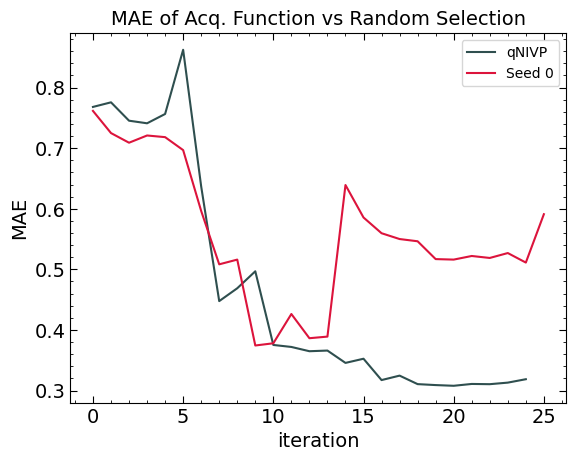

In [160]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
colors = ['crimson', 'blue', 'green', 'orange', 'purple']
for mae_values, seed, colors in zip(random_mae_seeds, random_seeds, colors):
    plt.plot(mae_values, label=f'Seed {seed}', color=colors)

    plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
    plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
    plt.minorticks_on()
    plt.title('MAE of Acq. Function vs Random Selection', size=14)
    plt.xlabel('iteration', size=14)
    plt.ylabel('MAE', size=14)
    plt.legend()
    plt.show()

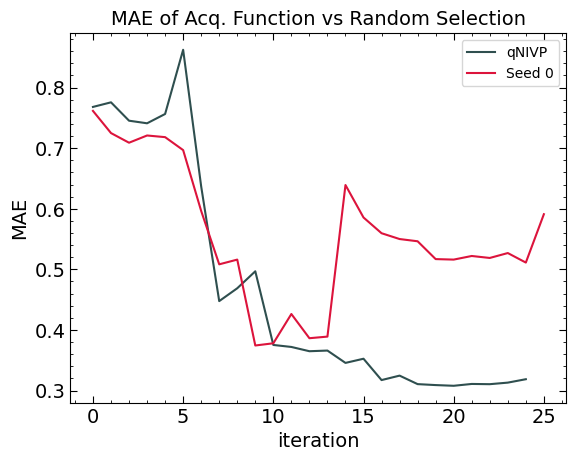

In [156]:
import matplotlib.pyplot as plt

random_seeds = [0, 13, 90, 14, 12]
 # Replace this with your actual lists of MAE values for each seed

plt.plot(pred_mae, color='darkslategray', label='qNIVP')
for mae_values, seed in zip(random_mae_seeds, random_seeds):
    plt.plot(mae_values, label=f'Seed {seed}', color='crimson')

plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k', labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection', size=14)
plt.xlabel('iteration', size=14)
plt.ylabel('MAE', size=14)
plt.legend()
plt.show()

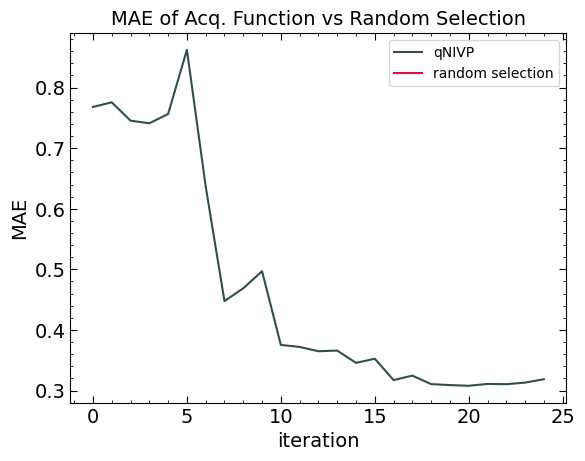

In [121]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(rand_pred_mae, color='crimson', label='random selection')
# plt.plot(ytest, ytest, color='blue')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection',size=14)
plt.xlabel('iteration',size=14)
plt.ylabel('MAE',size=14)
plt.legend()
plt.show()

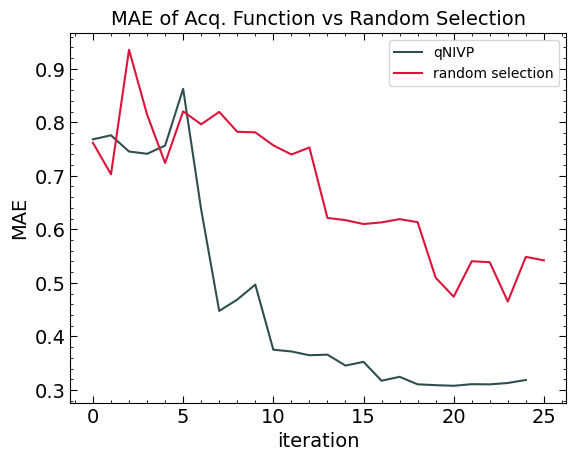

In [117]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(rand_pred_mae, color='crimson', label='random selection')
# plt.plot(ytest, ytest, color='blue')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection',size=14)
plt.xlabel('iteration',size=14)
plt.ylabel('MAE',size=14)
plt.legend()
plt.show()

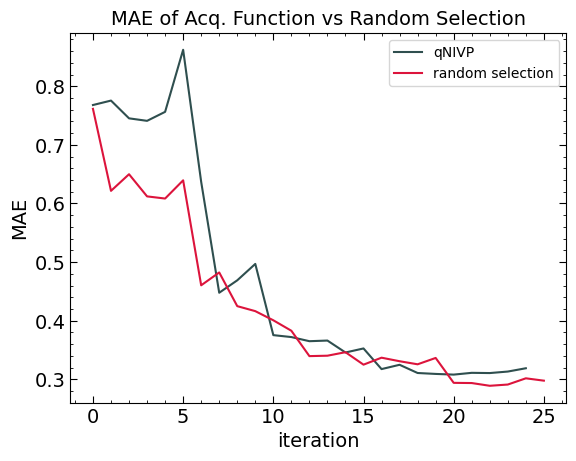

In [114]:
plt.plot(pred_mae, color='darkslategray', label='qNIVP')
plt.plot(rand_pred_mae, color='crimson', label='random selection')
# plt.plot(ytest, ytest, color='blue')
plt.tick_params(direction='in', which='major', length=5, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.tick_params(direction='in', which='minor', length=2, bottom=True, top=True, left=True, right=True, colors='k',labelsize=14)
plt.minorticks_on()
plt.title('MAE of Acq. Function vs Random Selection',size=14)
plt.xlabel('iteration',size=14)
plt.ylabel('MAE',size=14)
plt.legend()
plt.show()